In [ ]:
import numpy as np
import os
import matlab.engine
import matplotlib.pyplot as plt
from Camera_util import parse_video, parse_mean_video
import pandas as pd
from natsort import natsorted
import time
import Camera_util 
import importlib
import pickle

In [ ]:
importlib.reload(Camera_util)
recordings_dir = '/Users/zacharykelly/Aguirre-Brainard Lab Dropbox/Zachary Kelly/FLIC_data/recordings'
experiment_filename = '200FPS'
light_levels = [str(i) for i in range(4)]
Camera_util.generate_TTF(recordings_dir, experiment_filename, light_levels)

[-1.74768474e-04 -1.45352569e+00]
-0.00017476847384269694


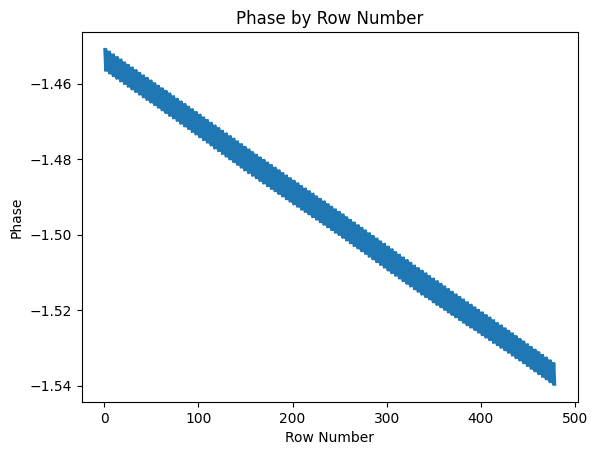

In [33]:
importlib.reload(Camera_util)
recordings_dir = '/Users/zacharykelly/Aguirre-Brainard Lab Dropbox/Zachary Kelly/FLIC_data/recordings'
light_levels = [str(i) for i in range(4)]

for light_level in light_levels:
    frequencies_to_test = {6, 12, 25}
    microseconds_per_row_list = []

    videos = [(os.path.join(recordings_dir, file), parse_video(os.path.join(recordings_dir, file))) for file in os.listdir(recordings_dir) if f"{light_level}NDF" in file]

    for (path, video) in videos:
        f = Camera_util.parse_recording_filename(os.path.split(path)[1])['frequency']

        if(f not in frequencies_to_test): continue

        slope = Camera_util.generate_row_phase_plot(video, f)
        secs_per_row = slope/(2*np.pi*f)
        microseconds_per_row_list.append(secs_per_row*1000000)

    microseconds_per_row_list = np.array(microseconds_per_row_list)

    exposure_time = 0 if light_level == '0' else 1
    mean_microseconds_per_row = np.mean(microseconds_per_row_list)
    std_microseconds_per_row = np.std(microseconds_per_row_list)

    plt.plot(exposure_time, mean_microseconds_per_row)
    plt.title('Mean Microseconds per Row by Exposure')
    plt.xlabel('Exposure Time')
    plt.ylabel('Mean Microseconds per Row')


